# Import essential packages

In [1]:
import tensorly as tl
from tensorly.decomposition import parafac as CP ## CP
from tensorly.decomposition import tucker  ## Tucker
from tensorly.decomposition import tensor_train as TT ## Tensor-trian
from tensorly import tucker_to_tensor
import tensorly.tenalg as talg

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from tqdm import trange
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import accuracy_score
import argparse
import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from dataloader import MnistBags
from mnist_bags_loader import MnistBags
from model import Attention, GatedAttention
from DataTransform import convert_data

In [4]:
target_number = 9 # bags have a positive labels if they contain at least one 9
mean_bag_length = 20 # average bag length
var_bag_length = 0 # variance of bag length
num_bags_train = 50 # the number of bags in training set
num_bags_test = 1000 # the number of bags in testing set
seed = 5 # random seed
use_cuda = torch.cuda.is_available()

In [5]:
use_cuda = torch.cuda.is_available()
print('Load Train and Test Set')
# loader_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data_utils.DataLoader(MnistBags(target_number= target_number,
                                               mean_bag_length= mean_bag_length,
                                               var_bag_length= var_bag_length,
                                               num_bag= num_bags_train,
                                               seed= seed,
                                               train=True),
                                     batch_size=1,
                                     shuffle=True,)

test_loader = data_utils.DataLoader(MnistBags(target_number= target_number,
                                              mean_bag_length= mean_bag_length,
                                              var_bag_length= var_bag_length,
                                              num_bag= num_bags_test,
                                              seed= seed,
                                              train=False),
                                    batch_size=1,
                                    shuffle=False,)



Load Train and Test Set


In [6]:
from net import *
from modules.criterion import *
data_type = "matrix" # matrix / tensor,  default = matrix
model_type = "attention" # attention
gate = False
img_sz = (28,28)
model = MIL(img_sz,data_type,model_type, gate)
### setting GPU
use_cuda = torch.cuda.is_available()
print("is cuda available: ",use_cuda)
if use_cuda:
    model = model.cuda()
learning_rate = 1 * 1e-4 ## 4
### define the optimization algorithm
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
## define criterion
criterion = attention_obj()
## the total number of iteration 
num_epochs = 50 ## 50
## weight decay
decay_weight = 1 # 0.98

_lambda = 0 * 1e-3  ## 0.01 default

is cuda available:  True


In [7]:
model.parameters

<bound method Module.parameters of MIL(
  (feature_extractor_part1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature_extractor_part2): Sequential(
    (0): Linear(in_features=2450, out_features=512, bias=True)
    (1): ReLU()
  )
  (attention_net): Attn_Net(
    (module): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features

## Run

In [8]:
from sklearn import metrics
# def train(epoch):
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0.
    # train_acc = 0.
    Y_label = []
    Y_hat_label = []
    for batch_idx,(data,label) in enumerate(train_loader):
        # data = torch.unsqueeze(data,2)
        bag_label = label[0] + 0.  ## convert true-false to 1-0
        ins_label = torch.tensor([0])
        if use_cuda:
            data, bag_label = data.cuda(), bag_label.cuda()
        # data, bag_label = Variable(data), Variable(bag_label)
        optimizer.zero_grad()
        # calculate loss and metrics
        y_hat,A = model(data) #data.float()
        loss = criterion(y_hat,bag_label)
        train_loss += loss.item()
        Y_label.append(bag_label.squeeze().detach().cpu().numpy())
        y_hat_label = torch.ge(y_hat, 0.5).float().detach().cpu().numpy()
        Y_hat_label.append(y_hat_label.squeeze())
        # backward pass
        loss.backward()
        # step
        optimizer.step()
    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    # train_acc = accuracy_score(Y_label,Y_hat_label)        
    fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_label)
    train_auc = metrics.auc(fpr, tpr)   
    # train_error /= len(train_loader)
    if epoch % 5 == 0:
    # print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))
        print('Epoch: {}, Loss: {:.8f}, Train auc: {:.6f}'.format(epoch, train_loss, train_auc))

Epoch: 5, Loss: 0.69761968, Train auc: 0.480000
Epoch: 10, Loss: 0.46348853, Train auc: 0.800000
Epoch: 15, Loss: 0.03157507, Train auc: 1.000000
Epoch: 20, Loss: 0.00527025, Train auc: 1.000000
Epoch: 25, Loss: 0.00206924, Train auc: 1.000000
Epoch: 30, Loss: 0.00100436, Train auc: 1.000000
Epoch: 35, Loss: 0.00056255, Train auc: 1.000000
Epoch: 40, Loss: 0.00035505, Train auc: 1.000000
Epoch: 45, Loss: 0.00024201, Train auc: 1.000000
Epoch: 50, Loss: 0.00017324, Train auc: 1.000000


## 2.2 Testing

<AxesSubplot:ylabel='Density'>

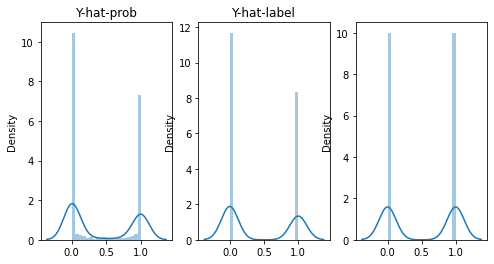

In [14]:
model.eval()
Y_label = []
Y_hat_label = []
ty_hat_list = []
tdata_list = []
ins_label_list = []
Y_hat_prob = []
for batch_idx, (data, label) in enumerate(test_loader):
    # data = torch.unsqueeze(data,2)
    bag_label = label[0] + 0  ## convert true-false to 1-0
    if use_cuda:
        data, bag_label = data.cuda(), bag_label.cuda()
    y_hat,attention_weights = model(data.float())
    y_hat_label = torch.ge(y_hat, 0.5).float()
    
    Y_label.append(bag_label.squeeze().detach().cpu().numpy())
    Y_hat_label.append(y_hat_label.squeeze().detach().cpu().numpy())
    Y_hat_prob.append(y_hat.squeeze().detach().cpu().numpy())
    tdata = data.detach().cpu().numpy().squeeze().squeeze()
    tdata_list.append(tdata)
    
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize = (8,4))
### presence-based
plt.subplot(1,3,1)
sns.distplot(Y_hat_prob,bins = 20)
plt.title("Y-hat-prob")
## lower-bound
plt.subplot(1,3,2)
plt.title("Y-hat-label")
sns.distplot(Y_hat_label,bins = 20)
plt.subplot(1,3,3)
sns.distplot(Y_label,bins = 20)

## Result

In [15]:
from utils import *
from sklearn import metrics

Y_hat_prob_ = [1 if x >=0.5 else 0 for x in Y_hat_prob]
fpr, tpr, thresholds = metrics.roc_curve(Y_label, Y_hat_prob)
TPR,TNR,ACC = cls_measure(Y_label,Y_hat_prob_)
test_auc = np.round(metrics.auc(fpr, tpr),5)
print("test auc: ",test_auc)
print("the acc of testing: ",ACC)
print("the tpr of testing: ",np.round(TPR,5))
print("the tnr of testing: ",np.round(TNR,5))

test auc:  0.90548
the acc of testing:  0.862
the tpr of testing:  0.778
the tnr of testing:  0.946


## 2.3 Plot

Ground truth:  1
the probability for a bag including number 9:  1.0


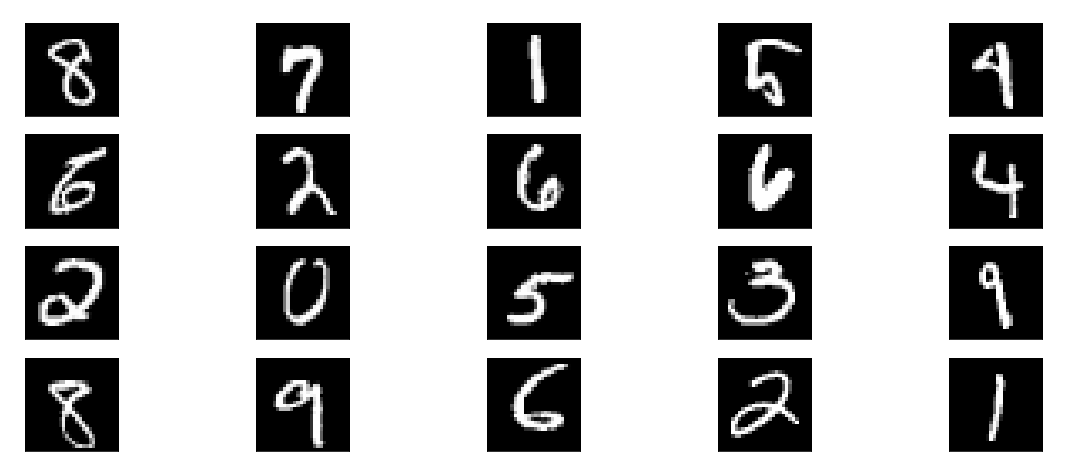

In [21]:
fig,ax = plt.subplots(figsize = (20,12))
k = 0
print("Ground truth: ",Y_label[k])
print("the probability for a bag including number 9: ",Y_hat_label[k])
for i in range(tdata.shape[0]):
    plt.subplot(6,5,i+1)
    plt.imshow(tdata[i,:,:],"gray")
    plt.title("Prob: " + str(Y_hat_prob[i]), color = "white")
    plt.xticks([])
    plt.yticks([])